In [1]:
import pandas as pd
import numpy as np
from dsipts import TimeSeries, RNN,read_public_dataset, LinearTS, Persistent, TFT,DilatedConvVAE
import matplotlib.pyplot as plt
from datetime import timedelta
import logging
import sys
import random




In [2]:
def random_walk(n,level=30):
    tot = np.zeros(n)
    probs = np.zeros(n)
    for i in range(n-1):
        prob = random.random()
        if prob<0.5:
            delta = 1
        else:
            delta = -1
        tot[i+1] = tot[i] + delta
        probs[i+1]= prob +(random.random()/level-0.5/level)
    return tot, probs

In [3]:
N = 20000
random.seed(18)
x, p = random_walk(N)
data = pd.DataFrame({'y':x/x.max(),'p':p,'time':range(N)})

In [4]:
##load the timeseries to the datastructure, adding the hour column and use all the covariates
ts = TimeSeries('weather')
ts.load_signal(data,enrich_cat=[],target_variables=['y'],past_variables= [],future_variables=['p'])
ts.set_verbose(True)
#Let now prepare a model predictin the next 16 step using the past 16 steps 
past_steps = 1
future_steps = 64

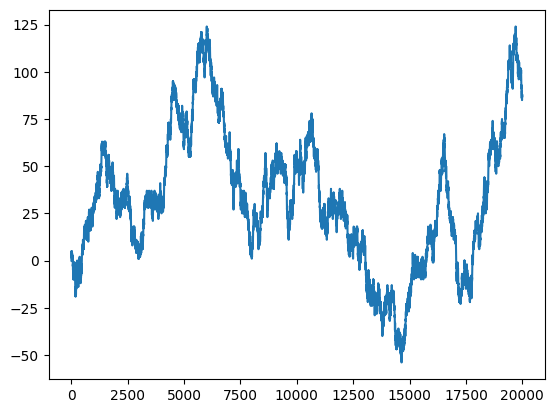

In [5]:
plt.plot(x)

In [6]:
ts.freq

1.0

In [7]:
split_params = {'perc_train':0.6,'perc_valid':0.2,                             ##if not None it will split 70% 10% 20%
               'range_train':None, 'range_validation':None, 'range_test':None, ## or we can split using ranges for example range_train=['2021-02-03','2022-04-08']
               'past_steps':past_steps,
               'future_steps':future_steps,
               'shift':0,
               'starting_point':None,                                          ## do not skip samples
               'skip_step' : 1                                                 ## distance between two consecutive samples
                             }

In [ ]:
res_tot = {}
for use_cumsum in [True,False]:
    for w in np.arange(0,1,0.5):
        print(w)
        config = dict(model_configs =dict(
                                            past_steps = past_steps,
                                            future_steps = future_steps,
                                            past_channels = len(ts.past_variables),
                                            future_channels = len(ts.future_variables),
                                            embs = [ts.dataset[c].nunique() for c in ts.cat_var],
                                            cat_emb_dim = 8,
                                            kernel_size = 1,
                                             use_bn = False,
                                            dropout_rate=0.0,
                                              optim='torch.optim.Adam',
                                              activation= 'torch.nn.GELU',
                                             sum_emb = True,
                                            use_cumsum=use_cumsum,
                                             out_channels = len(ts.target_variables),
                                            hidden_RNN=4,
                                            num_layers_RNN=1,                                  
                                            kind='gru',
                                            quantiles= [],
                                            persistence_weight =w,
                                            loss_type='exponential_penalization'
                                            ),
                        scheduler_config = dict(gamma=0.1,step_size=24000000000000000),
                        optim_config = dict(lr = 0.0005,weight_decay=0.00))
        model_linear = DilatedConvVAE(**config['model_configs'],optim_config = config['optim_config'],scheduler_config =config['scheduler_config'],verbose=True )
        ts.set_model(model_linear,config=config,custom_init=False )
        #train the model for 50 epochs with auto_lr_find 
        ts.train_model(dirpath=f"/home/agobbi/Projects/ExpTS/rf/c",
                       split_params=split_params,
                       batch_size=32,
                       num_workers=2,
                       max_epochs=250,
                       auto_lr_find=True)
        res = ts.inference_on_set(200,4,set='test',rescaling=True)
        res_tot[f'{w}_{use_cumsum}'] = res.copy()

0.0


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/c exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `va

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 7.585775750291836e-06
Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/rf/c/.lr_find_4e9fe654-03fc-4fbd-871a-7a0159b58f91.ckpt
Restored all states from the checkpoint file at /home/agobbi/Projects/ExpTS/rf/c/.lr_find_4e9fe654-03fc-4fbd-871a-7a0159b58f91.ckpt

  | Name                   | Type       | Params
------------------------------------------------------
0 | embs                   | ModuleList | 0     
1 | loss                   | L1Loss     | 0     
2 | initial_linear_encoder | Sequential | 4     
3 | initial_linear_decoder | Sequential | 4     
4 | conv_encoder           | Block      | 18    
5 | conv_decoder           | Block      | 170   
6 | Encoder                | GRU        | 72    
7 | Decoder                | GRU        | 72    
8 | final_linear_decoder   | Sequential | 91    
------------------------------------------------------
431       Trainable params
0         Non-traina

<Axes: >

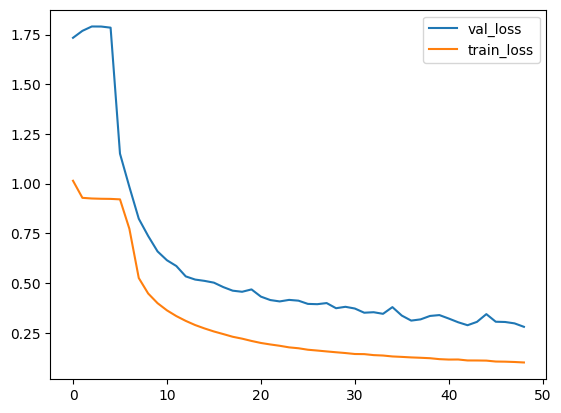

In [11]:
ts.losses.plot()



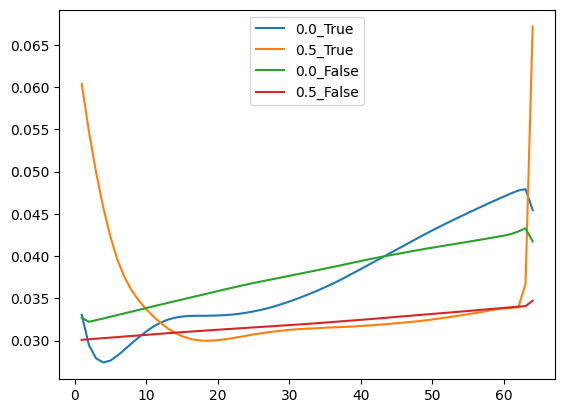

In [12]:
error = {}
for k in res_tot.keys():
    error[k] = res_tot[k].groupby('lag').apply(lambda x: np.sqrt(np.mean((x.y_pred-x.y)**2))).reset_index()
    plt.plot(error[k].lag, error[k][0],label=k)
plt.legend()

In [13]:
for i,k in enumerate(res_tot.keys()):
    res_tot[k]['prediction_time'] = res_tot[k].apply(lambda x: int(x.time-x.lag), axis=1)


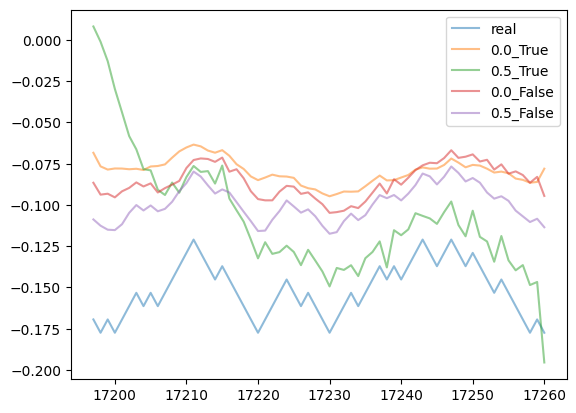

In [17]:
plt.figure()
date = 17196

for i,k in enumerate(res_tot.keys()):
    if i ==0:
        plt.plot( res_tot[k][ res_tot[k].prediction_time==date].time,  res_tot[k][ res_tot[k].prediction_time==date].y,label='real',alpha=0.5)
    plt.plot( res_tot[k][ res_tot[k].prediction_time==date].time,  res_tot[k][ res_tot[k].prediction_time==date].y_pred,label=k,alpha=0.5)
plt.legend()

In [22]:
for k in res_tot:
    print(k,res_tot[k].groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_pred)**2)).reset_index().rename(columns={0:'error'}).error.mean())

0.0_True 0.0015918354
0.5_True 0.0010160259
0.0_False 0.0014469901
0.5_False 0.0014469901


In [14]:
for k in res_tot:
    print(k,res_tot[k].groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_pred)**2)).reset_index().rename(columns={0:'error'}).error.mean())

0.0_True 0.001410989
0.5_True 0.001219033
0.0_False 0.0014469901
0.5_False 0.0010293971
